In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import SGD
import numpy as np
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
def resize_and_normalize_image(image):
    image = tf.image.resize(image,[32, 32])
    image = tf.image.rgb_to_grayscale(image)
    return image / 255.0

def convert_sample(data):

# Create a TensorFlow dataset from the training data features
    dataset = tf.data.Dataset.from_tensor_slices(data)

# Define a function to resize each image in the dataset

# Apply the resize function to each image in the dataset
    resized_dataset = dataset.map(resize_and_normalize_image)

# Convert the resized dataset to a NumPy array
    resized_arr = np.array(list(resized_dataset.as_numpy_iterator()))

    return resized_arr

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
device = '/GPU:0' if tf.config.list_physical_devices('GPU') else '/CPU:0'

In [ ]:
# Load the training data features

X_train_raw = np.load('/content/gdrive/My Drive/Assignment 2/Xtrain.npy')
print(f'Shape of the raw training data: {X_train_raw.shape}')

X_test_raw = np.load('/content/gdrive/My Drive/Assignment 2/Xtest.npy')
print(f'Shape of the raw test data: {X_test_raw.shape}')

X_train = convert_sample(X_train_raw)
print(f'Shape the resized training data: {X_train.shape}')

X_test = convert_sample(X_test_raw)
print(f'Shape the resized test data: {X_test.shape}')

y_raw = np.load('/content/gdrive/My Drive/Assignment 2/ytrain.npy')
y_raw = y_raw.reshape(-1,1)
print(f'Shape of the raw labels: {y_raw.shape}')

Shape of the raw training data: (26214, 96, 96, 3)
Shape of the raw test data: (1638, 96, 96, 3)
Shape the resized training data: (26214, 32, 32, 1)
Shape the resized test data: (1638, 32, 32, 1)
Shape of the raw labels: (26214, 1)


**Lets take a look at the data (images) before and after the transformation:**

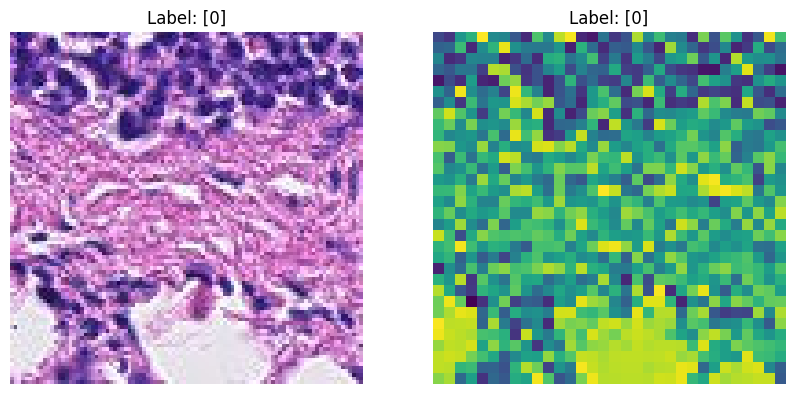

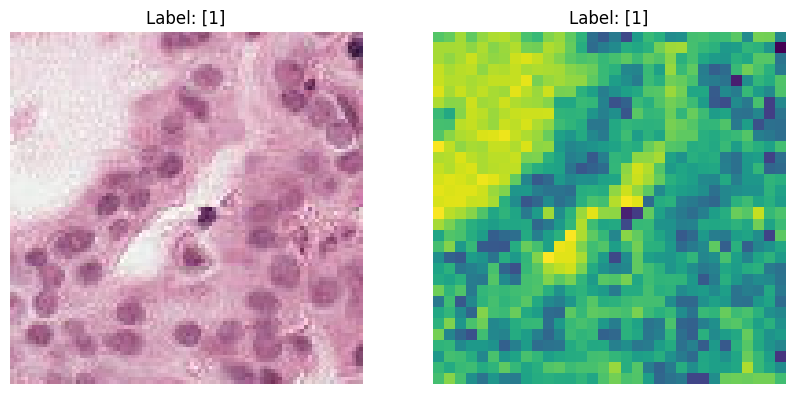

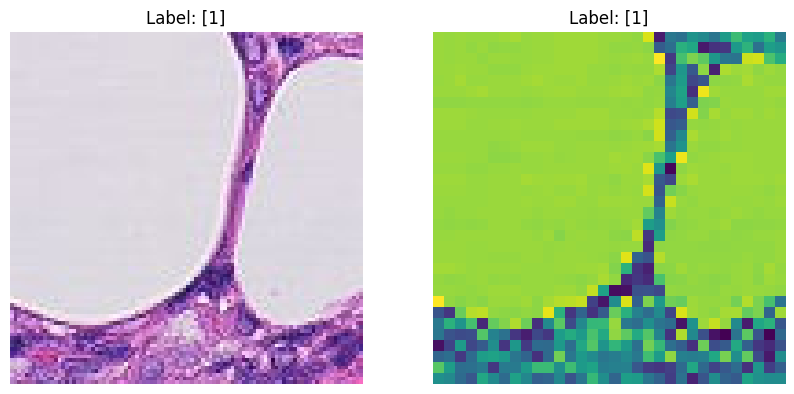

In [ ]:
for i in range(3):
    image_1 = X_train_raw[i]
    label_1 = y_raw[i]
    image_2 = X_train[i]
    label_2 = y_raw[i]

    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    axes[0].imshow(image_1)
    axes[0].set_title(f'Label: {label_1}')
    axes[0].axis('off')

    axes[1].imshow(image_2)
    axes[1].set_title(f'Label: {label_2}')
    axes[1].axis('off')

    plt.show()

**Create training data for the 3 ensembles:**

In [ ]:
num_ensembles = 3
samples_per_ensemble = X_train.shape[0] // num_ensembles

np.random.seed(42)

for i in range(1, 4):

    indices = np.random.choice(X_train.shape[0], samples_per_ensemble, replace=False)

    X_subset = X_train[indices]
    y_subset = y_raw[indices]

    globals()[f'X_{i}'] = X_subset
    globals()[f'y_{i}'] = y_subset

    X = np.delete(X_train, indices, axis=0)
    y = np.delete(y_raw, indices, axis=0)

**Print the shape of the ensambles:**

In [ ]:
for i in range(1,4):
    X = globals()[f'X_{i}']
    y = globals()[f'y_{i}']
    print(X.shape)
    print(y.shape)

(8738, 32, 32, 1)
(8738, 1)
(8738, 32, 32, 1)
(8738, 1)
(8738, 32, 32, 1)
(8738, 1)


**Model 1:**

In [ ]:
def build_model_1(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(32, 32, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.5))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_1 = tf.keras.models.Sequential(layers)
    model_1.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.SGD(0.0001, momentum=0.001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_1

**Model 2:**

In [ ]:
def build_model_2(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(32, 32, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.5))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_2 = tf.keras.models.Sequential(layers)
    model_2.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.Adagrad(0.001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_2

**Model 3:**

In [ ]:
def build_model_3(neurons_per_layer, activation, weight_regularizer, dropout, batch_norm):
    layers = [tf.keras.layers.Flatten(input_shape=(32, 32, 1))]

    for neurons in neurons_per_layer:
        layers.append(tf.keras.layers.Dense(neurons, activation=activation,
                                            kernel_regularizer=weight_regularizer))
        if batch_norm:
            layers.append(tf.keras.layers.BatchNormalization())
        if dropout:
            layers.append(tf.keras.layers.Dropout(0.5))

    layers.append(tf.keras.layers.Dense(2, activation='softmax'))

    model_3 = tf.keras.models.Sequential(layers)
    model_3.compile(
        loss='sparse_categorical_crossentropy',
        optimizer=tf.keras.optimizers.experimental.Adamax(0.0001),
        metrics=['sparse_categorical_crossentropy', 'accuracy'],
        )

    return model_3

**Define for all models:**

- optimal stopping
- layers
- validation_split
- epochs

In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                            patience=9,
                                            restore_best_weights=True)

neurons_per_layer_1 = [64, 128, 256, 256, 256, 128, 64]
neurons_per_layer_2 = [128, 128, 128, 128, 128, 128]
neurons_per_layer_3 = [64, 64, 128, 64, 64]


weight_regularizer_1 = tf.keras.regularizers.L2(0.01)
weight_regularizer_2 = tf.keras.regularizers.L2(0.01)
weight_regularizer_3 = tf.keras.regularizers.L2(0.01)

validation_split = 0.2

epochs = 200

**Build the models:**

In [ ]:

model_1 = build_model_1(neurons_per_layer_1, 'relu', weight_regularizer_1, None, True)
model_2 = build_model_2(neurons_per_layer_2, 'relu', weight_regularizer_2, None, True)
model_3 = build_model_3(neurons_per_layer_3, 'relu', weight_regularizer_3, None, True)

model_1.summary()
model_2.summary()
model_3.summary()


Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_18 (Flatten)        (None, 1024)              0         
                                                                 
 dense_130 (Dense)           (None, 64)                65600     
                                                                 
 batch_normalization_112 (B  (None, 64)                256       
 atchNormalization)                                              
                                                                 
 dense_131 (Dense)           (None, 128)               8320      
                                                                 
 batch_normalization_113 (B  (None, 128)               512       
 atchNormalization)                                              
                                                                 
 dense_132 (Dense)           (None, 256)             

**Fit the models:**

In [ ]:
history_1 = model_1.fit(
    X_1,
    y_1,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=[callback]
)

Epoch 1/200
219/219 [==============================] - 6s 14ms/step - loss: 12.3698 - sparse_categorical_crossentropy: 0.9262 - accuracy: 0.5469 - val_loss: 12.1959 - val_sparse_categorical_crossentropy: 0.7573 - val_accuracy: 0.5269
Epoch 2/200
219/219 [==============================] - 3s 14ms/step - loss: 12.3204 - sparse_categorical_crossentropy: 0.8868 - accuracy: 0.5715 - val_loss: 12.2343 - val_sparse_categorical_crossentropy: 0.8057 - val_accuracy: 0.5835
Epoch 3/200
219/219 [==============================] - 2s 11ms/step - loss: 12.2821 - sparse_categorical_crossentropy: 0.8585 - accuracy: 0.5810 - val_loss: 12.2833 - val_sparse_categorical_crossentropy: 0.8646 - val_accuracy: 0.5835
Epoch 4/200
219/219 [==============================] - 2s 11ms/step - loss: 12.2378 - sparse_categorical_crossentropy: 0.8241 - accuracy: 0.5893 - val_loss: 12.2581 - val_sparse_categorical_crossentropy: 0.8495 - val_accuracy: 0.6127
Epoch 5/200
219/219 [==============================] - 2s 10ms/s

In [ ]:
history_2 = model_2.fit(
    X_2,
    y_2,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=[callback]
)

Epoch 1/200
219/219 [==============================] - 5s 11ms/step - loss: 9.3490 - sparse_categorical_crossentropy: 0.7917 - accuracy: 0.6112 - val_loss: 9.2163 - val_sparse_categorical_crossentropy: 0.7343 - val_accuracy: 0.6064
Epoch 2/200
219/219 [==============================] - 3s 13ms/step - loss: 9.1024 - sparse_categorical_crossentropy: 0.6836 - accuracy: 0.6481 - val_loss: 9.0651 - val_sparse_categorical_crossentropy: 0.7071 - val_accuracy: 0.6419
Epoch 3/200
219/219 [==============================] - 2s 11ms/step - loss: 8.9569 - sparse_categorical_crossentropy: 0.6539 - accuracy: 0.6662 - val_loss: 8.9174 - val_sparse_categorical_crossentropy: 0.6682 - val_accuracy: 0.6602
Epoch 4/200
219/219 [==============================] - 2s 10ms/step - loss: 8.8147 - sparse_categorical_crossentropy: 0.6153 - accuracy: 0.6817 - val_loss: 8.8579 - val_sparse_categorical_crossentropy: 0.7077 - val_accuracy: 0.6636
Epoch 5/200
219/219 [==============================] - 2s 10ms/step - lo

In [ ]:
history_3 = model_3.fit(
    X_3,
    y_3,
    epochs=epochs,
    verbose=1,
    validation_split=validation_split,
    callbacks=[callback]
)

Epoch 1/200
219/219 [==============================] - 5s 12ms/step - loss: 5.0181 - sparse_categorical_crossentropy: 0.8706 - accuracy: 0.5551 - val_loss: 4.7682 - val_sparse_categorical_crossentropy: 0.6611 - val_accuracy: 0.6093
Epoch 2/200
219/219 [==============================] - 3s 12ms/step - loss: 4.8405 - sparse_categorical_crossentropy: 0.7610 - accuracy: 0.5974 - val_loss: 4.7741 - val_sparse_categorical_crossentropy: 0.7197 - val_accuracy: 0.6053
Epoch 3/200
219/219 [==============================] - 2s 9ms/step - loss: 4.7401 - sparse_categorical_crossentropy: 0.7082 - accuracy: 0.6352 - val_loss: 4.7416 - val_sparse_categorical_crossentropy: 0.7323 - val_accuracy: 0.6053
Epoch 4/200
219/219 [==============================] - 2s 9ms/step - loss: 4.6717 - sparse_categorical_crossentropy: 0.6835 - accuracy: 0.6419 - val_loss: 4.6844 - val_sparse_categorical_crossentropy: 0.7177 - val_accuracy: 0.6247
Epoch 5/200
219/219 [==============================] - 2s 9ms/step - loss:

**Model performence:**

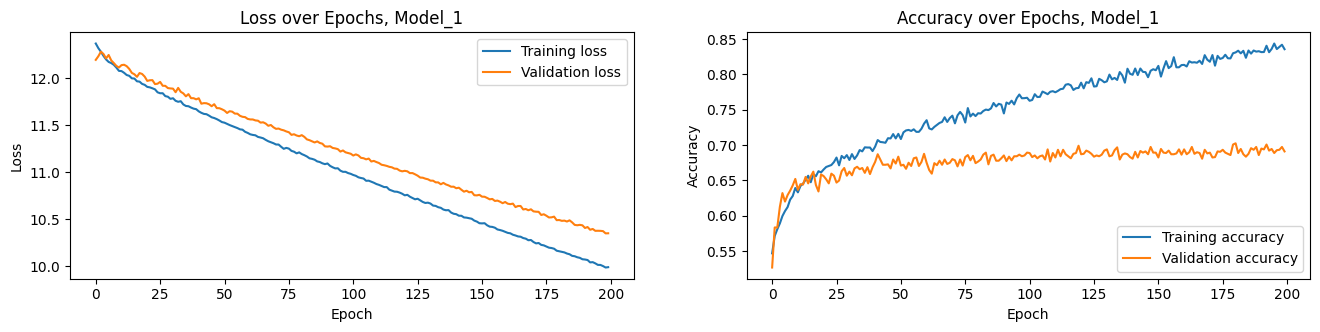

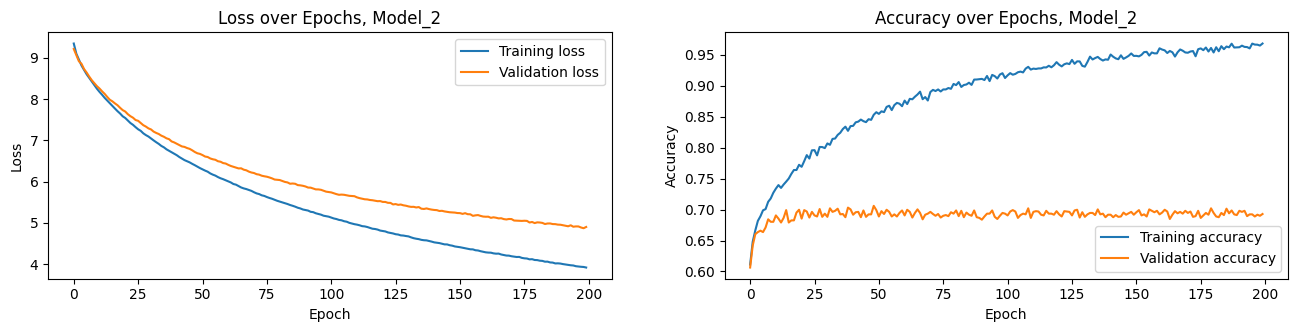

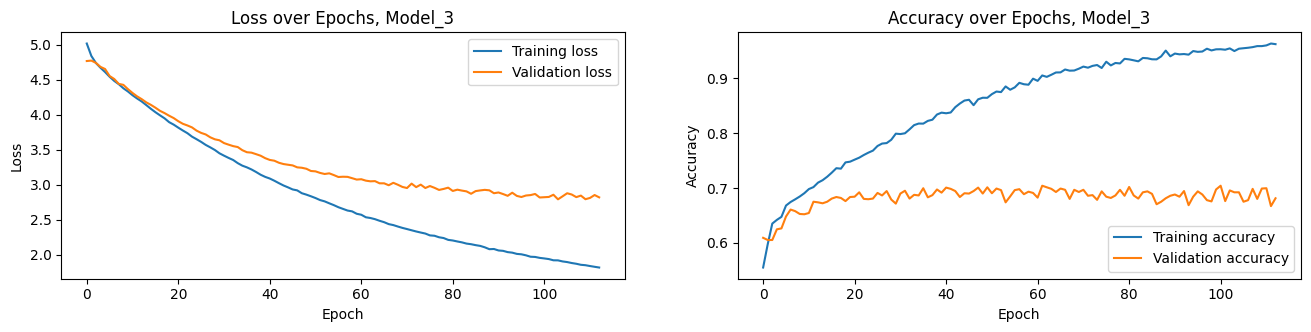

In [ ]:
for i in range(1,4):
    history_x = globals()[f'history_{i}']
    history_y = globals()[f'history_{i}']

    fig = plt.figure(figsize=plt.figaspect(0.2))


    ax = fig.add_subplot(1, 2, 1)
    ax.plot(history_x.history['loss'], label='Training loss')
    ax.plot(history_y.history['val_loss'], label='Validation loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Loss over Epochs, Model_{i}')
    plt.legend(loc='upper right')


    ax = fig.add_subplot(1, 2, 2)
    ax.plot(history_x.history['accuracy'], label='Training accuracy')
    ax.plot(history_y.history['val_accuracy'], label='Validation accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy over Epochs, Model_{i}')
    plt.legend(loc='lower right')

    plt.show()


**Majority vote:**

In [ ]:
df_ensemble = pd.DataFrame()

y_test_hat_1 = model_1.predict(X_test)
y_test_hat_1 = np.argmax(y_test_hat_1, axis=1)

y_test_hat_2 = model_2.predict(X_test)
y_test_hat_2 = np.argmax(y_test_hat_2, axis=1)

y_test_hat_3 = model_3.predict(X_test)
y_test_hat_3 = np.argmax(y_test_hat_3, axis=1)

df_ensemble['model_1'] = y_test_hat_1
df_ensemble['model_2'] = y_test_hat_2
df_ensemble['model_3'] = y_test_hat_3

def calculate_majority(row):
  counts = pd.Series(row).value_counts()
  majority = counts.idxmax()
  return majority

df_ensemble['majority'] = df_ensemble.apply(calculate_majority, axis=1)

print(df_ensemble)

52/52 [==============================] - 0s 2ms/step
      model_1  model_2  model_3  majority
0           0        1        0         0
1           1        0        1         1
2           0        1        1         1
3           0        0        0         0
4           1        1        1         1
...       ...      ...      ...       ...
1633        0        0        1         0
1634        0        1        0         0
1635        1        1        0         1
1636        0        0        1         0
1637        1        1        1         1

[1638 rows x 4 columns]


**Final prediction:**

In [ ]:
df_ensemble = pd.DataFrame({
    'Id': range(len(df_ensemble)),
    'Predicted': df_ensemble['majority'].values,
})

path_on_drive = '/content/gdrive/My Drive/Assignment 2/pred.csv'
df_ensemble.to_csv(path_on_drive, index=False)